# Explicación

El objetivo es extraer información de las noticias diarias de la web del Diario de El Comercio para poder analizar el comportamiento de ciertas pátrones de las publicaciones. Por ejemplo:
 - Momento del día que hay mayor cantidad de publicaciones
 - Quién es el autor que más noticias publica
 - Que tópico es el más publicado alrededor de los días
 - Palabras más utilizadas en los títulos de las publicaciones
 

# Código

## Instalación Librerias

In [39]:
# Import the libraries of BeautifulSoup and request
# Author: Daniel Eduardo Olivera Calderon
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from datetime import date, timedelta, datetime

## Extraccion

In [40]:
def iteration_news(param_list_news, final_list_news):
    # Iterar la lista de informacion de noticias
    for new_html in param_list_news:
        date_publish =  new_html.find_all('span', class_ = 'story-item__date-time')[0]
        date_publish = date_publish.get_text()

        time_publish = new_html.find_all('span', class_ = 'story-item__date-time')[1]
        time_publish = time_publish.get_text()

        section = new_html.find('a', class_='story-item__section text-sm text-black md:mb-15')
        section = section.get_text()

        title = new_html.find('a', class_='story-item__title block overflow-hidden primary-font line-h-xs mt-10')
        title = title.get_text()

        description = new_html.find('p', class_='story-item__subtitle overflow-hidden hidden mt-10 mb-10 text-md text-gray-200 line-h-xs')
        description = description.get_text()

        author = new_html.find('a', class_='story-item__author block uppercase mt-10 font-thin text-xs text-gray-200')
        author = author.get_text()

        link_new = new_html.find('a', class_='story-item__title block overflow-hidden primary-font line-h-xs mt-10')['href']
        link_new = link_new
        
        final_list_news.append([date_publish, time_publish, section, title, description, author, link_new])
    return final_list_news

In [41]:
# Iteracion de las noticias de la url de los 7 ultimos dias de noticias
def iteration_days(str_url):
    list_information_news = []
    url_initial = str_url
    for d in range(7):
        today = date.today() - timedelta(days=d+1)
        today = today.strftime('%Y-%m-%d')
        url_initial = str_url + today
    
        page = requests.get(url_initial)
        soup = BeautifulSoup(page.content, 'html.parser')
    
        body_html = soup.body
        div_html = body_html.find('div', class_="paginated-list--infinite")
        list_html_news = div_html.find_all('div', class_='story-item w-full pr-20 pl-20 pb-20 mb-20 border-b-1 border-solid border-gray md:pl-0 md:pr-0 lg:p-0')
        list_information_news = iteration_news(list_html_news, list_information_news)
        
    dataframe_news = pd.DataFrame(list_information_news, columns = ['Fecha', 'Hora', 'Seccion', 'Titulo', 'Descripcion', 'Autor', 'link'])
    
    return dataframe_news

In [42]:
# indicar la url de las noticias
url = "https://elcomercio.pe/archivo/todas/"
df_news_extract = iteration_days(url)

In [43]:
df_news_extract['extract_datetime'] = datetime.now()

In [46]:
df_news_extract.head()

,Fecha,Hora,Seccion,Titulo,Descripcion,Autor,link,extract_datetime
0,29/07/2024,23:57,Tramites,"Link, Revisa tus aportes a la ONP y cuánto has...",Sigue el paso a paso de la siguiente nota y co...,Redacción EC,/respuestas/tramites/consulta-tu-onp-2024-cono...,2024-07-30 00:10:52.050834
1,29/07/2024,23:56,Loterias,¿A qué hora y días se juega La Tinka y cómo ve...,"Entérate de todos los pormenores de La Tinka, ...",Redacción EC,/respuestas/loterias/la-tinka-hoy-28-de-julio-...,2024-07-30 00:10:52.050834
2,29/07/2024,23:56,Cuanto,¿Cuántos años deben pasar para que tu deuda en...,Entérate cuánto es el tiempo que debe pasar pa...,Redacción EC,/respuestas/cuanto/cuando-prescribe-una-deuda-...,2024-07-30 00:10:52.050834
3,29/07/2024,23:55,Respuestas,"Link, Padrón SISFOH 2024: Consulta si tu hogar...",Consulta el link oficial y el padrón de SISFOH...,Redacción EC,/respuestas/sisfoh-2024-tu-hogar-califica-como...,2024-07-30 00:10:52.050834
4,29/07/2024,23:54,Quién,¿Quiénes podrán tener DNI electrónico GRATIS d...,Quiénes podrán beneficiarse de esta iniciativa...,Redacción EC,/respuestas/quien/quienes-podran-tener-dni-ele...,2024-07-30 00:10:52.050834


In [47]:
df_news_extract.to_csv('fuente/extraccion/noticias_comercio.csv', index = False, sep = '|')

## Transformacion

In [48]:
df_news_transformation = df_news_extract.copy()

In [49]:
df_news_transformation = df_news_transformation[
    [
        'Fecha'
        ,'Hora'
        ,'Seccion'
        ,'Titulo'
        ,'Descripcion'
        ,'Autor'
        ,'link'
    ]
]

In [50]:
# Create a new column that save the hour (HH)
df_news_transformation['hora_extraida'] = df_news_transformation['Hora'].str.extract(r'(\d+)', expand=False)
df_news_transformation['hora_extraida'] = df_news_transformation['hora_extraida'].astype(str)

In [51]:
df_news_transformation['transformacion_datetime'] = datetime.now()

In [52]:
df_news_transformation.to_csv('fuente/transformacion/noticias_comercio.csv', index = False, sep = '|')

In [53]:
# Calculate and group by hour the news 
df_news_rank_hora = df_news_transformation.groupby('hora_extraida').size().reset_index(name='Q_news').sort_values(by='Q_news', ascending=False)
df_news_rank_hora

,hora_extraida,Q_news
9,22,99
10,23,83
7,20,82
4,17,81
5,18,80
3,16,76
6,19,71
8,21,62
2,15,29
1,14,21


In [54]:
# Rank 10 of authors that writes more news
df_rank_author = df_news_transformation.groupby('Autor').size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)
df_rank_author

,Autor,count
57,Redacción EC,463
3,Agencia EFE,85
1,Agencia AFP,22
35,José Cayetano Chávez,7
41,Marilia Pastor,6
12,Christian Cruz Valdivia,6
42,Martin Hidalgo Bustamante,6
8,BBC News Mundo,5
56,Pierina Denegri Davies,4
2,Agencia AP,4


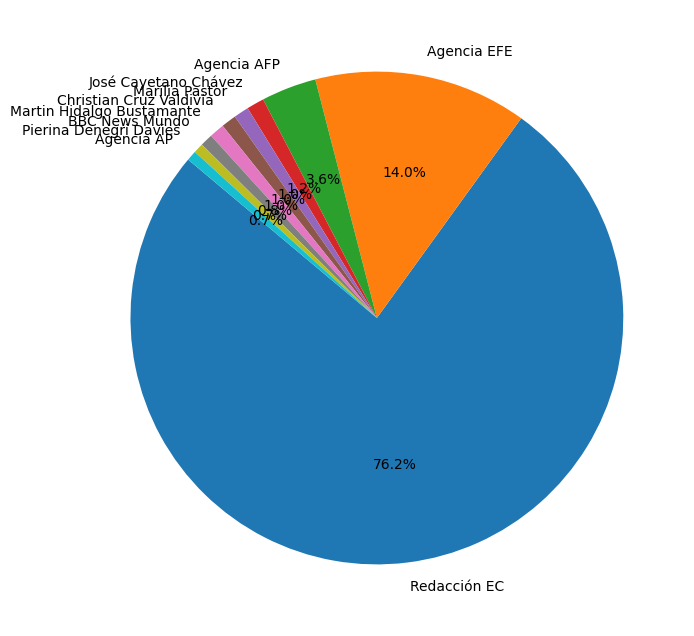

In [55]:
# A pie chart of the top 10 of the authors that writes more news
plt.figure(figsize=(8,8))
plt.pie(df_rank_author['count'], labels = df_rank_author['Autor'],autopct='%1.1f%%', startangle=140)
plt.show()

In [56]:
# Rank 10 of sections 
df_rank_seccion = df_news_transformation.groupby('Seccion').size().reset_index(name='count').sort_values(by='count', ascending = False).head(10)
df_rank_seccion

,Seccion,count
89,Venezuela,60
32,Fútbol peruano,48
69,Qué,38
14,Cual,33
63,Polideportivo,31
23,EEUU,29
2,Actualidad,25
31,Fútbol mundial,24
30,Farándula,21
41,Lima,18


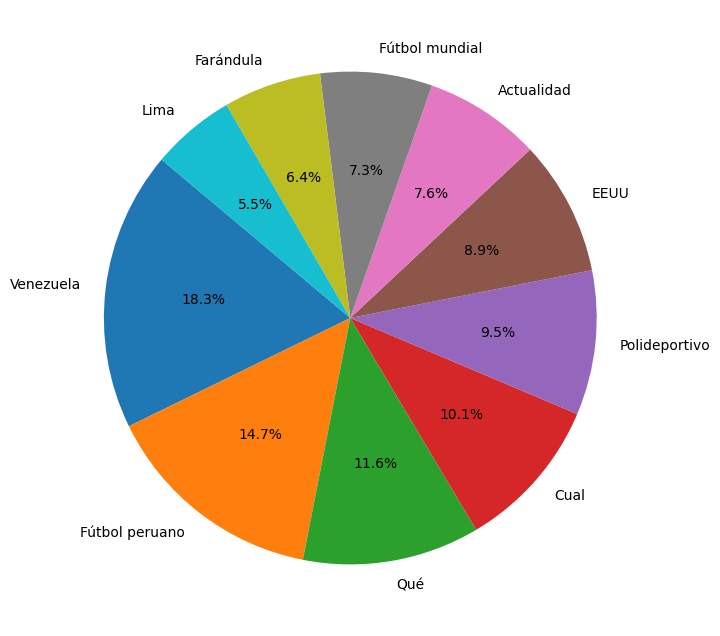

In [57]:
# A pie chart of the top 10 of sections that is more writes
plt.figure(figsize=(8,8))
plt.pie(df_rank_seccion['count'], labels = df_rank_seccion['Seccion'],autopct='%1.1f%%', startangle=140)
plt.show()

In [58]:
# Obtain a list of all words en all news
total_words = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es', 
                                                         'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta', 
                                                         'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
                                                         'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
                                                         'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han'
                             ,'mayo'])

In [59]:
for title in df_news_transformation['Titulo']:
    words = str(title).lower().split()
    for word in words:
        total_words = total_words + word + ' '

In [60]:
# Create the word cloud
word_cloud = WordCloud(width=800
                       , height = 600
                       , background_color = 'white'
                       , stopwords = stopwords
                       , min_font_size = 10
                      ).generate(total_words)

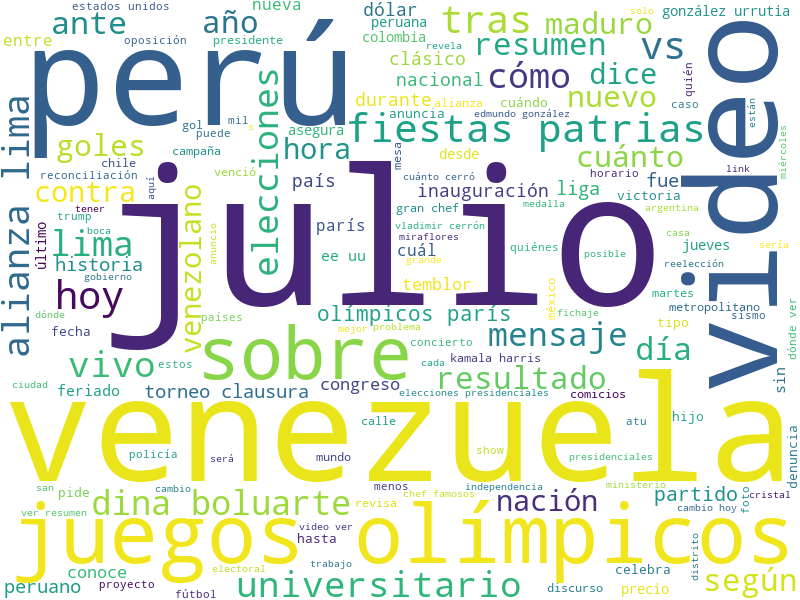

In [61]:
word_cloud.to_image()

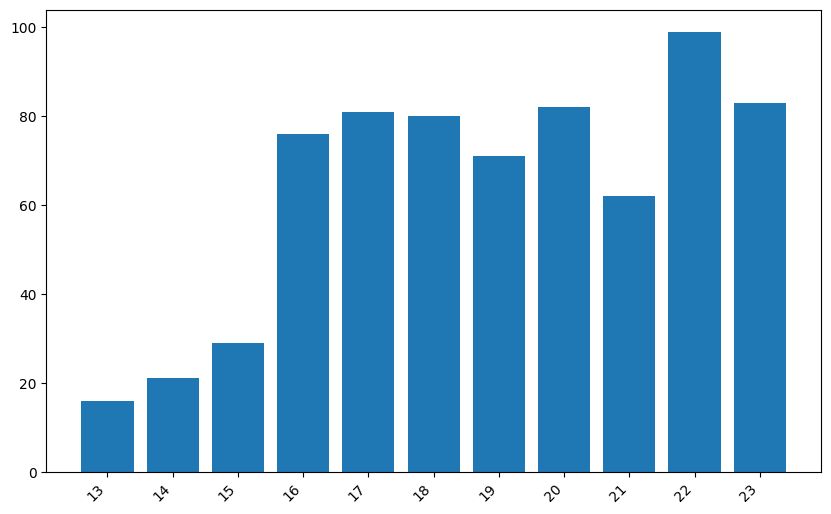

In [62]:
# Show in a graphic the behavior of the hours that the group news
df_news_rank_hora= df_news_rank_hora.sort_values(by='hora_extraida', ascending=True)
plt.figure(figsize=(10,6))
plt.bar(df_news_rank_hora['hora_extraida'], df_news_rank_hora['Q_news'])
plt.xticks(range(len(df_news_rank_hora['hora_extraida'])), df_news_rank_hora['hora_extraida'], rotation=45, ha='right')
plt.show()

## Exportar

In [64]:
df_news_transformation.to_csv('fuente/cargar/noticias_comercio.csv', index = False, sep = '|')

# Análisis de los datos


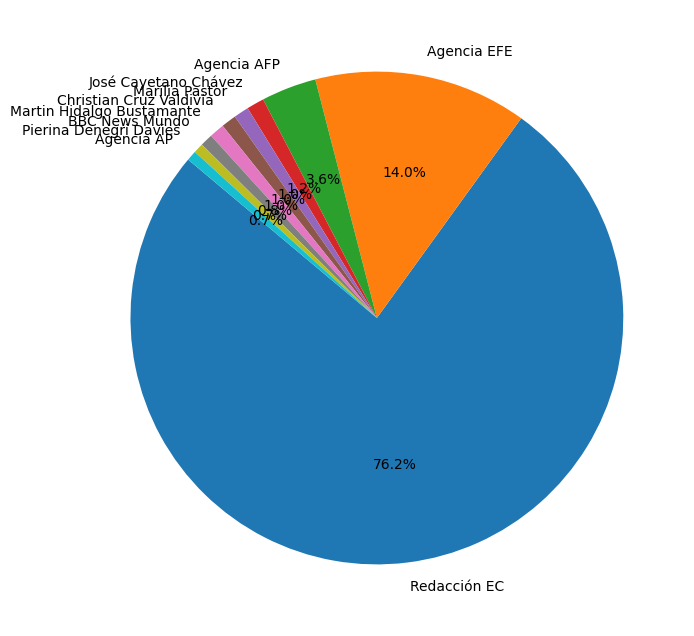

In [65]:
plt.figure(figsize=(8,8))
plt.pie(df_rank_author['count'], labels = df_rank_author['Autor'],autopct='%1.1f%%', startangle=140)
plt.show()

De acuerdo al pie chart el autor que publica mayor cantidad de mensajes es el usuario Redacción EC. Por lo que se puede indagar del nombre del usuario, debe ser una cuenta genérica utilizada para publicar, ya que las demás cuentas tienen nombre de cuentas de personas

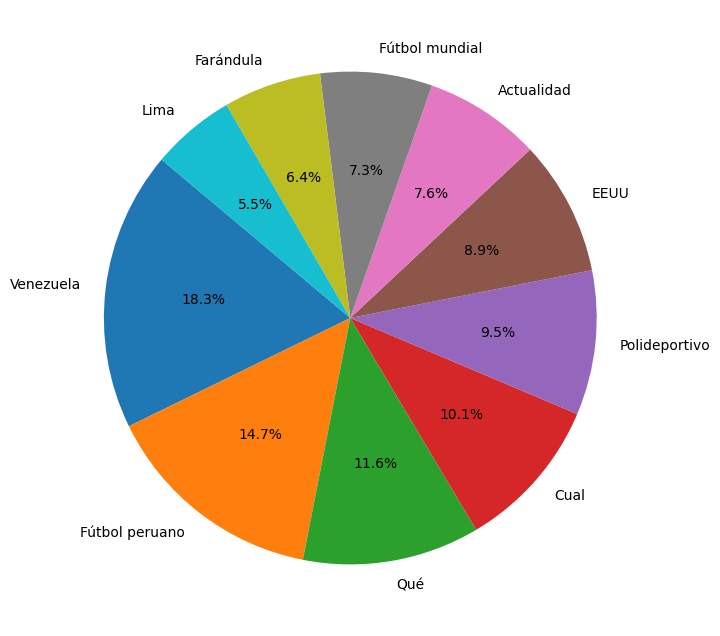

In [66]:
# A pie chart of the top 10 of sections that is more writes
plt.figure(figsize=(8,8))
plt.pie(df_rank_seccion['count'], labels = df_rank_seccion['Seccion'],autopct='%1.1f%%', startangle=140)
plt.show()

El piechart de rank sobre los temas de noticia con mayores publicaciones muestra que hasta la fecha de haber ejecutado el código venezuela  lleva la cabecera en cantidad de publicaciones, seguidamente de la sección 'Futbol Peruano' y de ahi viene Qué

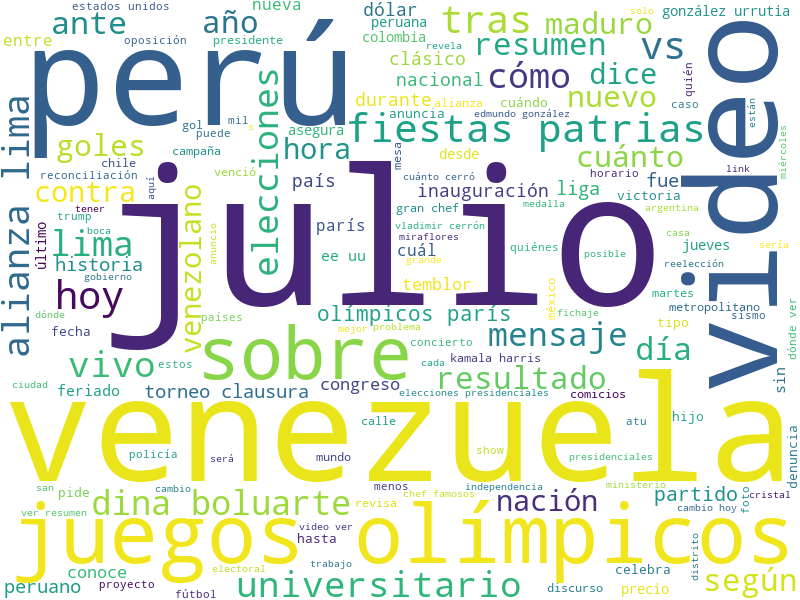

In [67]:
word_cloud.to_image()

Según la nube de palabras muestra que las palabras más utilizadas son Venezuela, Video, Julio, Perú. 
Estas palabras se pueden entender que son las más utilizadas porque el fin de semana hubo un partido de futbol (deporte muy popular en el pais).

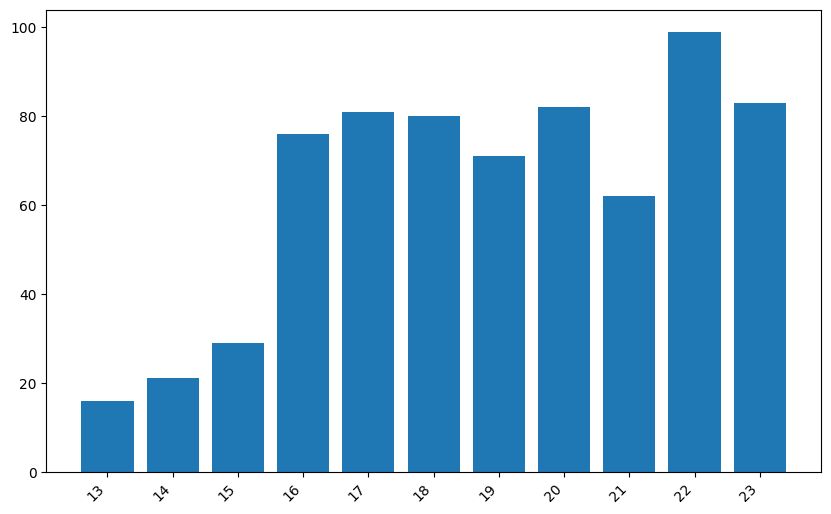

In [68]:
plt.figure(figsize=(10,6))
plt.bar(df_news_rank_hora['hora_extraida'], df_news_rank_hora['Q_news'])
plt.xticks(range(len(df_news_rank_hora['hora_extraida'])), df_news_rank_hora['hora_extraida'], rotation=45, ha='right')
plt.show()

Por último, por medio del gráfico de barras se puede analizar que la hora del día donde se publican mayor cantidad de noticias es a las 10pm, seguidamente de las 11pm y 8pm. La hora menos usada para publicaar es a la 1pm.